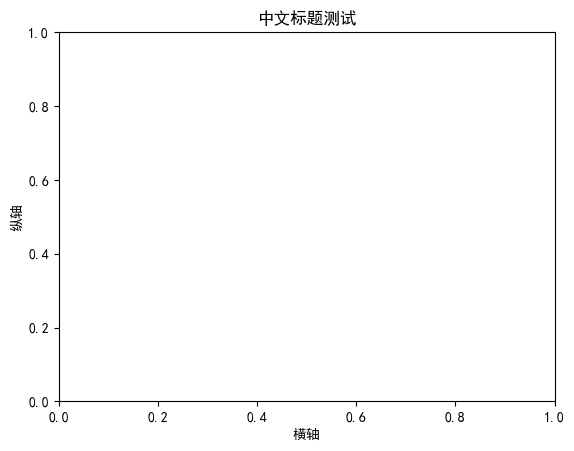

In [2]:
import matplotlib.pyplot as plt
import matplotlib

# 只保留系统已有的中文字体（优先用 SimHei 黑体，Windows 必装）
matplotlib.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

# 测试中文显示
plt.figure()
plt.title("中文标题测试")  # 此时应正常显示中文，无警告
plt.xlabel("横轴")
plt.ylabel("纵轴")
plt.show()

In [3]:
import os
import torch
import numpy as np

# 其他已有导入（保持不变）
import import_ipynb
import matplotlib.pyplot as plt
from data_loader import (
    load_images_from_dir, add_underwater_noise, preprocess_data
)
from model import DenoiseAE

# 1. 配置参数
TEST_IMG_DIR = r"C:\Users\27976\Desktop\UATD\UATD_Test_2\images"  # 替换为你的测试集路径
NUM_TEST = 800        # 测试样本数
IMAGE_SIZE = (256, 256)  # 图像尺寸
MODEL_PATH = "denoise_ae.pth"  # 模型路径
RESULTS_DIR = "results"        # 结果保存文件夹

# 确保结果文件夹存在
os.makedirs(RESULTS_DIR, exist_ok=True)

# 2. 加载测试数据
print("加载测试数据中...")
test_clean = load_images_from_dir(TEST_IMG_DIR, num_samples=NUM_TEST, size=IMAGE_SIZE)
test_noisy = np.array([add_underwater_noise(img) for img in test_clean])
test_clean_tensor, test_noisy_tensor = preprocess_data(test_clean, test_noisy)

# 3. 加载模型
model = DenoiseAE()
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))  # 支持CPU加载
model.eval()  # 切换到评估模式

# 4. 计算SNR（信噪比）
def calculate_snr(clean, denoised):
    """计算信噪比：越高表示降噪效果越好"""
    signal_power = np.var(clean)  # 信号功率（干净图像方差）
    noise_power = np.var(clean - denoised)  # 噪声功率（残差方差）
    return 10 * np.log10(signal_power / noise_power) if noise_power != 0 else 0

# 5. 生成降噪结果并评估
snr_before = []
snr_after = []
denoised_imgs = []

with torch.no_grad():  # 关闭梯度计算，加速评估
    for i in range(len(test_noisy_tensor)):
        # 模型预测
        noisy_input = test_noisy_tensor[i].unsqueeze(0)  # 加batch维度
        denoised_tensor = model(noisy_input)
        denoised_np = denoised_tensor.squeeze().numpy()  # 转为numpy数组
        
        # 计算SNR
        clean_np = test_clean_tensor[i].squeeze().numpy()
        noisy_np = test_noisy_tensor[i].squeeze().numpy()
        snr_before.append(calculate_snr(clean_np, noisy_np))
        snr_after.append(calculate_snr(clean_np, denoised_np))
        denoised_imgs.append(denoised_np)

# 6. 输出评估结果
print("="*50)
print("📊 降噪效果评估结果")
print("="*50)
print(f"降噪前平均SNR：{np.mean(snr_before):.2f} dB")
print(f"降噪后平均SNR：{np.mean(snr_after):.2f} dB")
print(f"SNR提升幅度：{np.mean(snr_after) - np.mean(snr_before):.2f} dB")
print("="*50)

# 7. 可视化并保存对比图（4组示例）
plt.figure(figsize=(20, 14), dpi=100)
for i in range(4):
    idx = np.random.randint(0, len(test_noisy))  # 随机选图
    
    # 干净图像
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(test_clean[idx], cmap='gray')
    plt.title("干净声呐图像", fontsize=14)
    plt.axis("off")
    
    # 含噪图像
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(test_noisy[idx], cmap='gray')
    plt.title(f"含噪图像（SNR：{snr_before[idx]:.2f} dB）", fontsize=14)
    plt.axis("off")
    
    # 降噪后图像
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(denoised_imgs[idx], cmap='gray')
    plt.title(f"降噪后图像（SNR：{snr_after[idx]:.2f} dB）", fontsize=14)
    plt.axis("off")

# 添加总标题
plt.suptitle(
    f"水下声呐图像降噪效果对比（平均SNR提升：{np.mean(snr_after) - np.mean(snr_before):.2f} dB）\n"
    f"降噪前：{np.mean(snr_before):.2f} dB | 降噪后：{np.mean(snr_after):.2f} dB",
    fontsize=18, y=0.99
)
plt.tight_layout()

# 保存对比图
result_path = os.path.join(RESULTS_DIR, "denoise_result.png")
plt.savefig(result_path, bbox_inches='tight')
plt.close()
print(f"降噪对比图已保存至：{result_path}")

加载测试数据中...


C:\Users\27976\AppData\Local\Temp\ipykernel_32908\2335792241.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=t

📊 降噪效果评估结果
降噪前平均SNR：-15.37 dB
降噪后平均SNR：0.79 dB
SNR提升幅度：16.17 dB
降噪对比图已保存至：results\denoise_result.png
